# LSTM

In [115]:
import dlc_bci as bci
import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

In [116]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, '--', c=c[0], label='Train loss')
    plt.plot(val_losses, c=c[0], label='Val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(train_accs, '--', c=c[1], label='Train acc')
    plt.plot(val_accs, c=c[1], label='Val acc')
    plt.legend(loc='best')

## 1 Loading and transforming the data

In [117]:
train_input, train_target = bci.load(root = './data_bci', train=True, one_khz=True)
print(str(type(train_input)), train_input.size())
print(str(type(train_target)), train_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])


In [118]:
test_input, test_target = bci.load(root = './data_bci', train=False, one_khz=True)
print(str(type(test_input)), test_input.size())
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([100, 28, 500])
<class 'torch.LongTensor'> torch.Size([100])


In [119]:
train_input = train_input.permute(0,2,1)
test_input = test_input.permute(0,2,1)

## 1.1 Standardizing the data

In [120]:
def standardize_data(input_data, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = input_data.contiguous().view(-1, 28).mean(dim=0)
        std_dev = input_data.contiguous().view(-1, 28).std(dim=0)
    return (input_data - mean) / std_dev, mean, std_dev

In [121]:
train_input, mean, std_dev = standardize_data(train_input)
test_input, _, _ = standardize_data(test_input, mean, std_dev)

## 1.2 Data augmentation

In [122]:
def augment_dataset(train_input, train_target, std_dev, multiple):
    new_train_input = train_input.clone()
    new_train_target = train_target.clone()
    for i in range(multiple-1):
        augmented_input = train_input + torch.zeros(train_input.shape).normal_(0, std_dev)
        new_train_input = torch.cat((new_train_input, augmented_input))
        new_train_target = torch.cat((new_train_target, train_target))
    return new_train_input, new_train_target

In [123]:
train_input, train_target = augment_dataset(train_input, train_target, 0.1, 30)

## 1.3 Creating the Dataset / Dataloader

In [124]:
train_input.shape, test_input.shape

(torch.Size([9480, 500, 28]), torch.Size([100, 500, 28]))

In [125]:
train_dataset = TensorDataset(train_input, train_target)
test_dataset = TensorDataset(test_input, test_target)

In [126]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
dset_loaders = {'train': trainloader, 'val': testloader}
dset_sizes = {'train': len(train_input), 'val': len(test_input)}

## 2 Defining the model architecture

In [127]:
#seq = train_input.shape[1] # 500
#input_size = train_input.shape[2] #28

class Net(torch.nn.Module):
    def __init__(self, input_size, batch_size, hidden_size=32, num_layers=2, dropout=0.2):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        # LSTM input size is: (batch, seq, feature)
        # LSTM output size is: (batch, seq, hidden_size)
        self.lstm = torch.nn.LSTM(input_size=input_size,
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  batch_first=True,
                                  dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.lstm(x)[0][:,-1,:] # take only last output of LSTM (many-to-one RNN)
        x = x.view(x.shape[0], -1) # flatten to (batch, hidden_size)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size):
        # Initializing the hidden layer
        # The axes semantics are (num_layers, minibatch_size, hidden_dim) (with batch_first=false)
        return (Variable(torch.zeros(self.batch_size, self.num_layers, self.hidden_size)),
                Variable(torch.zeros(self.batch_size, self.num_layers, self.hidden_size)))

## 3 Training models

In [128]:
def train_model(model, criterion, optimizer, lr_scheduler=None, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if lr_scheduler:
                    optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                #_, preds = torch.max(outputs.data, 1)
                preds = outputs
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                preds_classes = preds.data.max(1)[1]
                running_corrects += torch.sum(preds_classes == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model, train_losses, val_losses, train_accs, val_accs

In [129]:
def k_fold_cv(model, train_input, train_target, criterion, optimizer, lr_scheduler=None,\
              num_epochs=25, K=5, shuffle=True, random_seed=42, verbose=2,
              augment_multiplier=0, std_dev=0.1):
    n_train = len(train_input)
    indices = list(range(n_train))
    n_validation = n_train // K
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    avg_train_loss, avg_val_loss = 0, 0
    avg_train_acc, avg_val_acc = 0, 0
        
    for k in range(K):
        indices_rolled = np.roll(indices, k * n_train // K)
        train_idx, val_idx = indices_rolled[n_validation:], indices_rolled[:n_validation]
        
        train_inp = train_input[train_idx,]
        train_tar = train_target[train_idx,]
        val_inp = train_input[val_idx,]
        val_tar = train_target[val_idx,]
        
        train_inp, train_tar = augment_dataset(train_inp, train_tar, std_dev, augment_multiplier)
        
        #train_sampler = SubsetRandomSampler(train_idx) #sampler=train_sampler
        #val_sampler = SubsetRandomSampler(val_idx) #sampler=val_sampler
        
        train_dataset = TensorDataset(train_inp, train_tar)
        val_dataset = TensorDataset(val_inp, val_tar)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
        dset_loaders = {'train': train_loader, 'val': val_loader}
        dset_sizes = {'train': len(train_inp), 'val': len(val_inp)}
        
        if verbose:
            print('CV k={}:'.format(k))
        _, train_losses, val_losses, train_accs, val_accs = train_model(copy.deepcopy(model), dset_loaders, 
                                                                        dset_sizes, criterion, optimizer, 
                                                                        num_epochs=num_epochs, verbose=verbose)
        
        avg_train_loss += min(train_losses)
        avg_val_loss += min(val_losses)
        avg_train_acc += max(train_accs)
        avg_val_acc += max(val_accs)
        
    avg_train_loss /= K
    avg_val_loss /= K
    avg_train_acc /= K
    avg_val_acc /= K
        
    if verbose:
        print('\nAvg best train loss: {:.2f}, avg best val loss: {:.2f}'.format(avg_train_loss, avg_val_loss))
        print('Avg best train acc: {:.6f}%, avg best val acc: {:.6f}%'.format(avg_train_acc*100, avg_val_acc*100))
        
    return avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc

### 3.1 One layer, 256 hidden units

In [130]:
model = Net(train_input.shape[2], batch_size, hidden_size=256, num_layers=2, dropout=0.5)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
weight_decay = 1e-3 # L2 regularizer parameter
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

if torch.cuda.is_available():
    model.cuda()
    criterion.cuda()

In [131]:
best_model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=250)

Epoch 0/249
----------
train Loss: 0.0179 Acc: 0.6889
val Loss: 0.0258 Acc: 0.6900

Epoch 1/249
----------
train Loss: 0.0117 Acc: 0.8496
val Loss: 0.0241 Acc: 0.7300

Epoch 2/249
----------
train Loss: 0.0098 Acc: 0.8735
val Loss: 0.0267 Acc: 0.7600

Epoch 3/249
----------
train Loss: 0.0086 Acc: 0.8964
val Loss: 0.0297 Acc: 0.7100

Epoch 4/249
----------
train Loss: 0.0079 Acc: 0.9053
val Loss: 0.0322 Acc: 0.7400

Epoch 5/249
----------
train Loss: 0.0085 Acc: 0.8988
val Loss: 0.0331 Acc: 0.7400

Epoch 6/249
----------
train Loss: 0.0076 Acc: 0.9143
val Loss: 0.0348 Acc: 0.7500

Epoch 7/249
----------
train Loss: 0.0073 Acc: 0.9164
val Loss: 0.0351 Acc: 0.7500

Epoch 8/249
----------
train Loss: 0.0061 Acc: 0.9347
val Loss: 0.0426 Acc: 0.7000

Epoch 9/249
----------
train Loss: 0.0058 Acc: 0.9385
val Loss: 0.0446 Acc: 0.7000

Epoch 10/249
----------
train Loss: 0.0050 Acc: 0.9546
val Loss: 0.0400 Acc: 0.7300

Epoch 11/249
----------
train Loss: 0.0044 Acc: 0.9615
val Loss: 0.0463 Acc

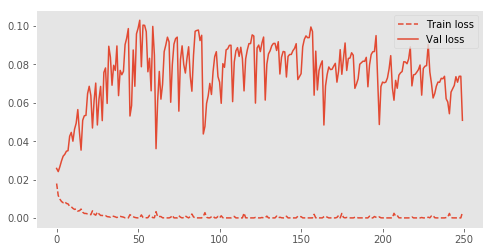

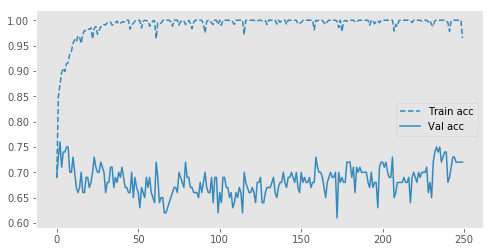

In [132]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

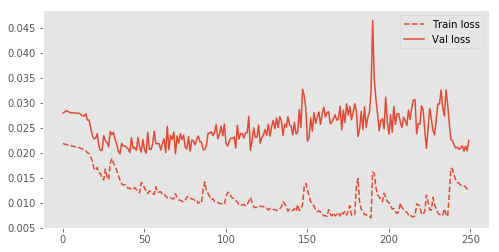

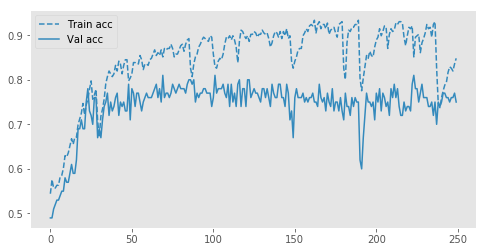

In [81]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

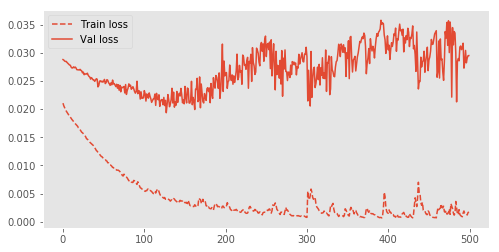

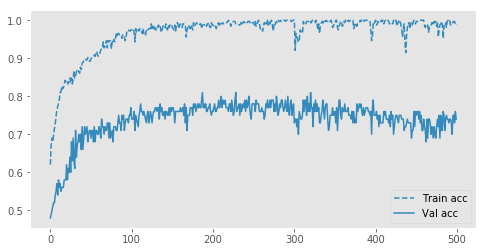

In [60]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

In [ ]:
_,_,_,_ = k_fold_cv(model, train_input, train_target, criterion, optimizer, 
                    num_epochs=250, K=5, shuffle=True, random_seed=42, verbose=1,
                    augment_multiplier=0, std_dev=0.1)

### Etc

In [63]:
train_input_var = Variable(train_input.cuda())
train_target_var = Variable(train_target.cuda(), requires_grad=False)

test_input_var = Variable(test_input.cuda())
test_target_var = Variable(test_target.cuda(), requires_grad=False)

In [66]:
pred_test = best_model(test_input_var).data
pred_test_classes = pred_test.max(1)[1]
accuracy_score(pred_test_classes, test_target)

/home/roman/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().


0.81000000000000005

In [67]:
pred_train = best_model(train_input_var).data
pred_train_classes = pred_train.max(1)[1]
accuracy_score(pred_train_classes, train_target)

/home/roman/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().


0.990506329113924